In [1]:
print("og")

og


In [2]:
print("hello")

hello


In [3]:
import pandas as pd
file_path = r"C:\Users\SanjeevMuddala\Documents\GitHub\Loan-Default-Prediction\Loan Default Prediction\Loan_default.csv"
data = pd.read_csv(file_path)
# print(data.head())
# print
print(data.isnull().sum())

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


In [4]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder as labelEncoder

categorical_cols = data.select_dtypes(include=['object']).columns

#step 2
le = labelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

numerical_cols = data.select_dtypes(include = ['int64','float64']).columns
scalar = StandardScaler()
data[numerical_cols] = scalar.fit_transform(data[numerical_cols])

print(data.head)
print(data.info())


<bound method NDFrame.head of           LoanID       Age    Income  LoanAmount  CreditScore  MonthsEmployed  \
0       0.004802  0.833990  0.089693   -1.086833    -0.341492        0.590533   
1      -0.030266  1.701221 -0.823021   -0.044309    -0.731666       -1.285731   
2      -0.574395  0.166888  0.043854    0.022715    -0.775718       -0.968209   
3       1.254281 -0.767053 -1.303452   -1.168538     1.061875       -1.718715   
4      -0.297467  1.100830 -1.592855   -1.671921     0.369631       -1.487790   
...          ...       ...       ...         ...          ...             ...   
255342 -0.931839 -1.634285 -1.142632    1.173101    -0.209337        1.427636   
255343 -0.841528 -0.767053 -0.783984    0.879724    -0.398130       -1.314597   
255344  1.514401  0.833990  0.059562    1.139391     0.143078        0.301877   
255345  0.121567 -0.099952  0.066979   -0.945840     1.477221       -0.564091   
255346  1.714435  1.234250 -1.542012   -1.540048     0.388510        1.543098  

In [5]:
target = "Default"

numerical_cols = data.select_dtypes(include = ['int64','float64']).columns

scalar = StandardScaler()
data[numerical_cols] = scalar.fit_transform(data[numerical_cols])

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculates correlation between numerical features.
# print("Default Value Counts:\n", data["Default"].value_counts())
data["Default"].value_counts()


Default
-0.362472    225694
 2.758835     29653
Name: count, dtype: int64

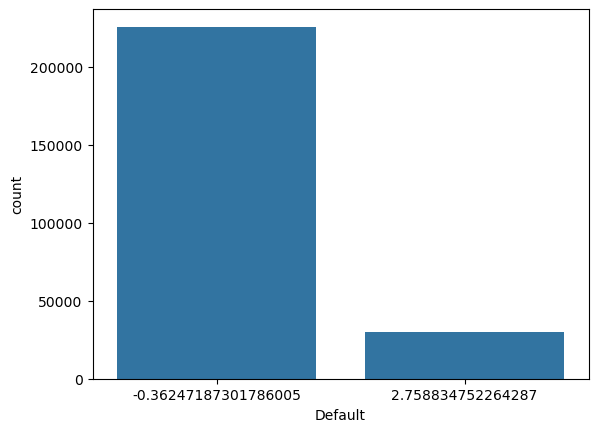

In [7]:
sns.countplot(x="Default", data=data)
plt.show()

In [8]:
#### FEATURE ENGINEERING: Create new features that may enhance model performance, 
# such as debt-to-income ratio, loan
data["DTIRatio"] = data["LoanAmount"] / (data["Income"])

In [9]:
data["CreditScore"] = pd.cut(
    data["CreditScore"],
    bins=[0, 600, 700, 750, 850],
    labels=[0, 1, 2, 3]
)
# Fill NaNs with a default value, e.g., -1, then convert to int
data["CreditScore"] = data["CreditScore"].cat.add_categories([-1]).fillna(-1).astype(int)


In [10]:
#3]Train Classification Models: Logistic Regression,
#  Decision Trees, 
# Random Forest, 
# Gradient Boosting (XGBoost, LightGBM).
# Explore different models and compare their performance.
 
#3A) train - test split(needed before allmodels).

from sklearn.model_selection import train_test_split
data["Default"] = data["Default"].astype(int)
X = data.drop("Default", axis=1)
Y = data["Default"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)
  

print(X_train.shape, X_test.shape)

(204277, 17) (51070, 17)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Convert continuous target to categorical (e.g., 0 and 1)
# Here, we map the lowest value to 0 and the highest to 1
Y_train_cat = (Y_train == Y_train.max()).astype(int)
Y_test_cat = (Y_test == Y_test.max()).astype(int)

# #create model
log_reg = LogisticRegression(max_iter=1000) #increasing the iterations so converges
#train the model
log_reg.fit(X_train, Y_train_cat)
#make predictions on test set
Y_pred = log_reg.predict(X_test)
print(accuracy_score(Y_test_cat, Y_pred))
print(classification_report(Y_test_cat, Y_pred))

# print(data.dtypes)
# print(data.head())

# --- Find and fix the target scaling issue ---

# Before scaling, separate the target column
target = "Default"
feature_cols = data.columns.drop(target)

# Only scale features, not the target
scalar = StandardScaler()
data[feature_cols] = scalar.fit_transform(data[feature_cols])

# Ensure target is integer (binary classification: 0 or 1)
data[target] = data[target].astype(int)

# Train-test split
from sklearn.model_selection import train_test_split
X = data.drop(target, axis=1)
Y = data[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print(X_train.shape, X_test.shape)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# No need to convert target to categorical if already 0/1
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, Y_train)
Y_pred = log_reg.predict(X_test)
# Predict probability for the positive class (default = 2)
Y_prob = log_reg.predict_proba(X_test)[:, 1]  # column 1 corresponds to class 2


# accuracy = accuracy_score(Y_test, Y_pred)
# print("Accuracy:", accuracy)

0.8849618171137654
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.60      0.03      0.05      5931

    accuracy                           0.88     51070
   macro avg       0.74      0.51      0.50     51070
weighted avg       0.85      0.88      0.84     51070

(204277, 17) (51070, 17)


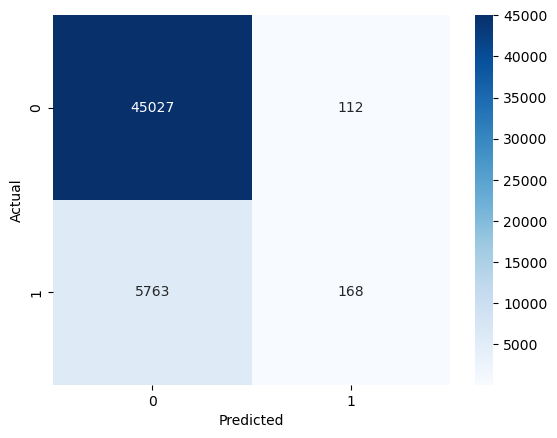

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [22]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           2       0.60      0.03      0.05      5931

    accuracy                           0.88     51070
   macro avg       0.74      0.51      0.50     51070
weighted avg       0.85      0.88      0.84     51070



In [23]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


# Split first
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)

print("Before SMOTE:", X_train.shape, Y_train.value_counts())
print("After SMOTE:", X_train_res.shape, Y_train_res.value_counts())

Before SMOTE: (204277, 17) Default
0    180555
2     23722
Name: count, dtype: int64
After SMOTE: (361110, 17) Default
0    180555
2    180555
Name: count, dtype: int64


In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

# Ensure the model is fitted before calling predict_proba
# If you get an error, re-run the cell where log_reg.fit(X_train, Y_train) is called

# Predict probabilities for the positive class (class 2.758835)
Y_prob = log_reg.predict_proba(X_test)[:, 1]  # index 1 for positive class

# Compute ROC curve using correct pos_label
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob, pos_label=2.758835)

# Compute AUC
auc_score = roc_auc_score(Y_test, Y_prob)
print("AUC-ROC Score:", auc_score)


AUC-ROC Score: 0.7488930733445628


c:\Users\SanjeevMuddala\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [25]:
import pickle
with open("loan_default_model.pkl", "wb") as f:
    pickle.dump(log_reg, f)

In [26]:
#loading
with open("loan_default_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
Y_pred = loaded_model.predict(X_test)

In [27]:
Y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

# Since X_train is already numeric and scaled, you do not need further preprocessing.
pipeline = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, Y_train)
joblib.dump(pipeline, "loan_default_model.pkl")


['loan_default_model.pkl']